<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/39_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from transformers import pipeline

In [9]:
# model = pipeline(model="seara/rubert-tiny2-russian-sentiment")
# model("Я тебя ненавижу")

Device set to use cpu


[{'label': 'negative', 'score': 0.9315334558486938}]

In [2]:
%%capture
!pip install emoji==1.4.1
!pip install imblearn

In [3]:
import numpy as np
import pandas as pd
import re, string
import emoji
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
seed=42
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
plt.style.use("Solarize_Light2")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)
import warnings
warnings.filterwarnings("ignore")

<Figure size 640x480 with 0 Axes>

In [4]:
df = pd.read_csv("/content/sms_spam.csv", encoding='ISO-8859-1')
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [5]:
df.head(1)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN


In [6]:
df.rename(columns={"v1": "spam"}, inplace=True)
df.rename(columns={"v2": "text"}, inplace=True)
df = df[['spam','text']]

In [7]:
df_train = df[:5000]
df_test = df[5001:]

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   spam    5000 non-null   object
 1   text    5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 5001 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   spam    571 non-null    object
 1   text    571 non-null    object
dtypes: object(2)
memory usage: 9.1+ KB


In [10]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels = ['ham', 'spam']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Тест', fontsize=20)
    ax.set_xlabel('Предсказание', fontsize=20)
    plt.show()

In [11]:
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #удаляем emoji (смайлики)

# Удаляем пунктуацию, ссылки, упоминание других участников, символы конца строки и переноса \r\n
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() # удаляем \n и \r и переводим строку в нижний регистр
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) # удаление ссылок и упоминаний других участников
    text = re.sub(r'[^\x00-\x7f]',r'', text) # удаление символов не utf8/ascii, таких как '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§' # символы для удаления, включая пунктуацию
    table = str.maketrans('', '', banned_list) # создание словаря замены
    text = text.translate(table) # применение к строке словаря замены
    return text

# убираем хэштеги в конце предложения и оставляем в середине, удалив только символ #
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) # удаление последнего хэштега
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) # удаление символа хэштега в середине предложения
    return new_tweet2

# Фильтрация специальных символов, таких как & и $, присутствующих в некоторых словах
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # удаление множественных пробелов с помощью регулярки
    return re.sub("\s\s+" , " ", text)

In [12]:
texts_new = []
for t in df_train.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [13]:
texts_new_test = []
for t in df_test.text:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [14]:
df_train['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [15]:
df_train['text_clean'].head(3)

,text_clean
0,go until jurong point crazy available only in ...
1,ok lar joking wif u oni
2,free entry in 2 a wkly comp to win fa cup fina...


In [16]:
df_test['text_clean'].head(3)

,text_clean
5001,you still around looking to pick up later
5002,cds 4u congratulations ur awarded 500 of cd gi...
5003,theres someone here that has a year ltgt toyot...


In [17]:
text_len = []
for text in df_train.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df_train['text_len'] = text_len

In [18]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

df_test['text_len'] = text_len_test

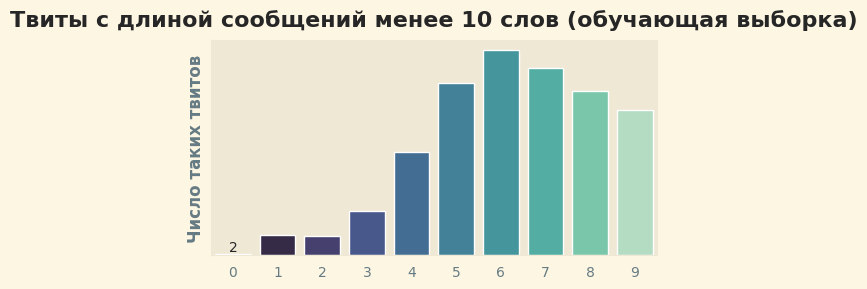

In [19]:
plt.figure(figsize=(5,3))
ax = sns.countplot(x='text_len', data=df_train[df_train['text_len']<10], palette='mako')
plt.title('Твиты с длиной сообщений менее 10 слов (обучающая выборка)')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число таких твитов')
plt.xlabel('')
plt.show()

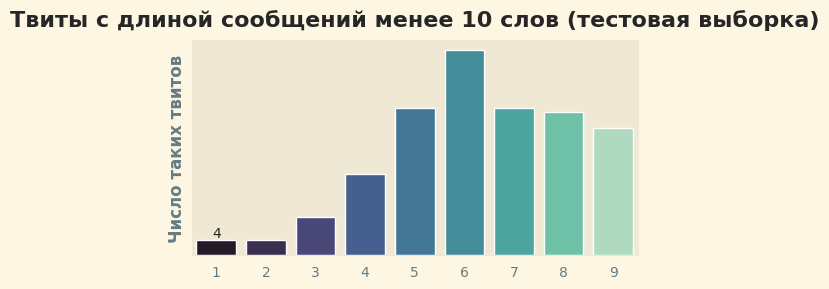

In [20]:
plt.figure(figsize=(5,3))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Твиты с длиной сообщений менее 10 слов (тестовая выборка)')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число таких твитов')
plt.xlabel('')
plt.show()

In [21]:
print(f"Форма обучающей выборки: {df_train.shape}")
print(f"Форма тестовой выборки: {df_test.shape}")

Форма обучающей выборки: (5000, 4)
Форма тестовой выборки: (571, 4)


In [22]:
df_train = df_train[df_train['text_len'] > 3]
df_test = df_test[df_test['text_len'] > 3]

In [23]:
print(f"Форма обучающей выборки после очистки: {df_train.shape}")
print(f"Форма тестовой выборки после очистки: {df_test.shape}")

Форма обучающей выборки после очистки: (4842, 4)
Форма тестовой выборки после очистки: (553, 4)


In [24]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
token_lens = []

for txt in df_train['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)
print(f"Максимальная длина токенизированной последовательности: {max_len}")

Максимальная длина токенизированной последовательности: 203


In [26]:
token_lens = []

for i,txt in enumerate(df_train['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 151, TEXT: you are everywhere dirt on the floor the windows even on my shirt and sometimes when i open my mouth you are all that comes flowing out i dream of my world without you then half my chores are out too a time of joy for me lots of tv shows ill see but i guess like all things you just must exist like rain hail and mist and when my time here is done you and i become one
INDEX: 810, TEXT: sir i have been late in paying rent for the past few months and had to pay a ltgt charge i felt it would be inconsiderate of me to nag about something you give at great cost to yourself and thats why i didnt speak up i however am in a recession and wont be able to pay the charge this month hence my askin well ahead of months end can you please help thanks
INDEX: 1050, TEXT: for me the love should start with attractioni should feel that i need her every time around meshe should be the first thing which comes in my thoughtsi would start the day and end it with hershe should be there every t

In [27]:
df_train['token_lens'] = token_lens

In [28]:
df_train = df_train.sort_values(by='token_lens', ascending=False)
df_train.head(5)

,spam,text,text_clean,text_len,token_lens
1084,ham,For me the love should start with attraction.i...,for me the love should start with attractioni ...,171,203
1862,ham,The last thing i ever wanted to do was hurt yo...,the last thing i ever wanted to do was hurt yo...,162,181
2157,ham,Sad story of a Man - Last week was my b'day. M...,sad story of a man last week was my bday my wi...,115,127
2847,ham,Sad story of a Man - Last week was my b'day. M...,sad story of a man last week was my bday my wi...,115,127
2433,ham,Indians r poor but India is not a poor country...,indians r poor but india is not a poor country...,107,125


In [29]:
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [30]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)
print(f"Максимальная длина токенизированной последовательности: {max_len}")

Максимальная длина токенизированной последовательности: 119


In [31]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 101, TEXT: a boy loved a gal he propsd bt she didnt mind he gv lv lttrs bt her frnds threw thm again d boy decided 2 aproach d gal dt time a truck was speeding towards d gal wn it was about 2 hit d girld boy ran like hell n saved her she asked hw cn u run so fast d boy replied boost is d secret of my energy n instantly d girl shouted our energy n thy lived happily 2gthr drinking boost evrydy moral of d story i hv free msgsd gud ni8


In [32]:
df_test['token_lens'] = token_lens_test

In [33]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(5)

,spam,text,text_clean,text_len,token_lens
5104,ham,A Boy loved a gal. He propsd bt she didnt mind...,a boy loved a gal he propsd bt she didnt mind ...,95,119
5129,ham,"Rose for red,red for blood,blood for heart,hea...",rose for redred for bloodblood for heartheart ...,58,72
5374,ham,Do u konw waht is rael FRIENDSHIP Im gving yuo...,do u konw waht is rael friendship im gving yuo...,39,72
5264,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...",storming msg wen u lift d phne u say hello do ...,53,71
5535,ham,"I know you are thinkin malaria. But relax, chi...",i know you are thinkin malaria but relax child...,61,70


In [34]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [35]:
df_train['spam'].value_counts()

,count
spam,
ham,4172
spam,670


In [36]:
df_train['spam'] = df_train['spam'].map({'ham':0, 'spam' :1})
df_test['spam'] = df_test['spam'].map({'ham':0, 'spam' :1})

In [37]:
df_train['spam'].value_counts()

,count
spam,
0,4172
1,670


In [38]:
df_test['spam'].value_counts()

,count
spam,
0,479
1,74


In [55]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df_train['text_clean']).reshape(-1, 1), np.array(df_train['spam']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'spam']);

In [56]:
train_os['spam'].value_counts()

,count
spam,
1,4172
0,4172


In [63]:
X = train_os['text_clean'].values
y = train_os['spam'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

X_test = df_test['text_clean'].values
y_test = df_test['spam'].values

y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [64]:
ohe = preprocessing.OneHotEncoder() # создаем экземпляр класса OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [65]:
print(f"Тренировочная выборка: {X_train.shape[0]}")
print(f"Проверочная выборка: {X_valid.shape[0]}")
print(f"Тестовая выборка: {X_test.shape[0]}")

Тренировочная выборка: 7509
Проверочная выборка: 835
Тестовая выборка: 553


In [86]:
# BERT
def tokenize(data, max_len=128) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

In [87]:
train_input_ids, train_attention_masks = tokenize(X_train)
val_input_ids, val_attention_masks = tokenize(X_valid)
test_input_ids, test_attention_masks = tokenize(X_test)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7509,) + inhomogeneous part.